In [1]:
from datasets import load_dataset,DatasetDict

# Load IMDB dataset
imdb = load_dataset("imdb")

# Check label distribution (0 = negative, 1 = positive)
print(imdb["train"].to_pandas()["label"].value_counts())

# Sample 10% from each split for faster training
imdb = DatasetDict({
    split: ds.shuffle(seed=42).select(range(int(0.05 * len(ds))))
    for split, ds in imdb.items()
})

imdb


c:\git\quanitze\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


label
0    12500
1    12500
Name: count, dtype: int64


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1250
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1250
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 2500
    })
})

In [2]:
from transformers import TrainingArguments
def get_args(): 
    return TrainingArguments(
        output_dir="working_dir",
        per_device_train_batch_size=6,
        per_device_eval_batch_size=32,
        bf16=True,  
        eval_strategy="epoch",
        seed=42, 
        data_seed=42,
    )

In [3]:
def print_model_structure(model):
    print("Model structure:")
    for name, module in model.named_modules():
        print(f"- {name}")
        
print_model_structure(model)

NameError: name 'model' is not defined

In [8]:
import torch
def get_gpu_memory():
    """Returns GPU memory usage in MB"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # Clear cache first
        return torch.cuda.memory_allocated() / 1024**2
    return 0

print("Initial GPU memory usage:", get_gpu_memory(), "MB")

Initial GPU memory usage: 0.0 MB


In [34]:
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig

# Configure quantization
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

model_name = 'answerdotai/ModernBERT-base'
tokenizer = AutoTokenizer.from_pretrained(model_name, max_tokenz=1024)

# Measure memory before loading base model
print("\nLoading base model...")
before_base = get_gpu_memory()
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model = model.cuda()  # Explicitly move to GPU
after_base = get_gpu_memory()
print(f"Base model memory usage: {after_base - before_base:.2f} MB")

# Print model device to confirm
print(f"Model device: {next(model.parameters()).device}")

def tok_fn(example): 
    return tokenizer(example['text'], truncation=True)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Loading base model...
Base model memory usage: 588.79 MB
Model device: cuda:0
Base model memory usage: 588.79 MB
Model device: cuda:0


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_full(model, test_dataset, name="Model"):
    """Evaluate model with detailed metrics"""
    print(f"\nEvaluating {name}...")
    
    all_predictions = []
    all_labels = []
    model.eval()
    
    batch_size = 32
    with torch.no_grad():
        for i in range(0, len(test_dataset), batch_size):
            batch = test_dataset[i:i + batch_size]
            inputs = tokenizer(batch['text'], 
                             padding=True, 
                             truncation=True, 
                             return_tensors="pt").to('cuda')
            
            outputs = model(**inputs)
            predictions = outputs.logits.argmax(-1).cpu().numpy()
            labels = batch['label']
            
            all_predictions.extend(predictions)
            all_labels.extend(labels)
        
    
    # Calculate metrics
    print(f"\n{name} Classification Report:")
    print(classification_report(all_labels, all_predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'predictions': all_predictions,
        'labels': all_labels
    }

Starting detailed model evaluation...

Evaluating Base Model...

Base Model Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.88      0.64       631
           1       0.42      0.09      0.15       619

    accuracy                           0.49      1250
   macro avg       0.46      0.48      0.39      1250
weighted avg       0.46      0.49      0.39      1250


Base Model Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.88      0.64       631
           1       0.42      0.09      0.15       619

    accuracy                           0.49      1250
   macro avg       0.46      0.48      0.39      1250
weighted avg       0.46      0.49      0.39      1250



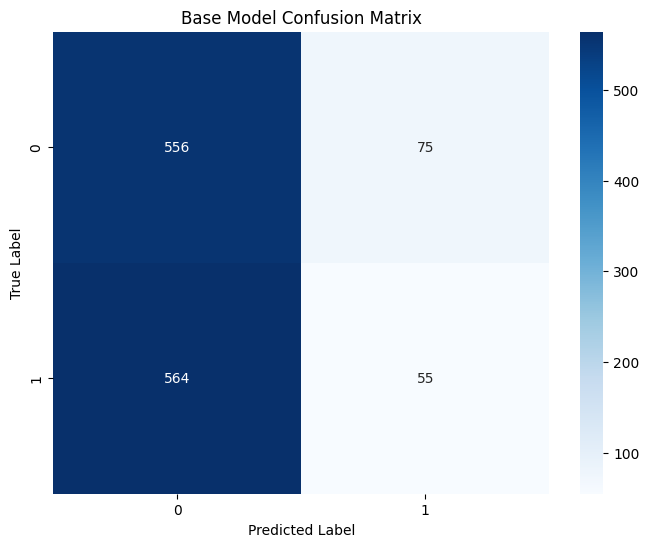


Evaluating Quantized Model...

Quantized Model Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64       631
           1       0.59      0.30      0.40       619

    accuracy                           0.55      1250
   macro avg       0.56      0.55      0.52      1250
weighted avg       0.56      0.55      0.52      1250


Quantized Model Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64       631
           1       0.59      0.30      0.40       619

    accuracy                           0.55      1250
   macro avg       0.56      0.55      0.52      1250
weighted avg       0.56      0.55      0.52      1250



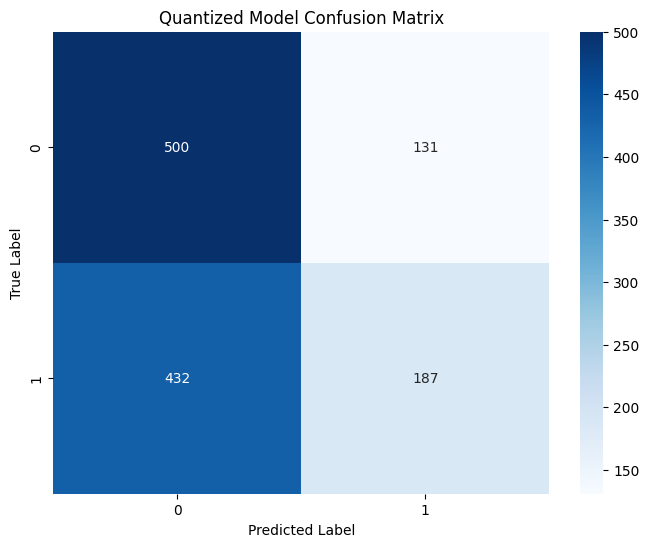


Model Agreement Analysis:
----------------------------------------
Total samples tested: 1250
Number of matching predictions: 898
Agreement rate: 0.7184
Disagreement rate: 0.2816

Reminder - Memory Usage:
----------------------------------------
Base Model Memory: 588.79 MB
Quantized Model Memory: 180.76 MB
Memory Savings: 408.04 MB


In [41]:
# Run evaluation on test subset
print("Starting detailed model evaluation...")

# Get a subset of test data
test_subset = imdb['test'].select(range(1250))  # Using 2000 examples for better statistics

# Evaluate both models
base_results = evaluate_model_full(model, test_subset, "Base Model")
quantized_results = evaluate_model_full(quantized_model, test_subset, "Quantized Model")

# Calculate agreement between models
agreement = sum(b == q for b, q in zip(base_results['predictions'], quantized_results['predictions']))
agreement_rate = agreement / len(base_results['predictions'])

print("\nModel Agreement Analysis:")
print("-" * 40)
print(f"Total samples tested: {len(base_results['predictions'])}")
print(f"Number of matching predictions: {agreement}")
print(f"Agreement rate: {agreement_rate:.4f}")
print(f"Disagreement rate: {1 - agreement_rate:.4f}")

# Memory comparison reminder
print("\nReminder - Memory Usage:")
print("-" * 40)
print(f"Base Model Memory: {after_base - before_base:.2f} MB")
print(f"Quantized Model Memory: {after_quantized - before_quantized:.2f} MB")
print(f"Memory Savings: {(after_base - before_base) - (after_quantized - before_quantized):.2f} MB")

In [ ]:
def evaluate_model(model, test_dataset, name="Model"):
    """Evaluate model accuracy on test dataset"""
    print(f"\nEvaluating {name}...")
    
    correct = 0
    total = 0
    model.eval()  # Set to evaluation mode
    
    # Process in batches to be memory efficient
    batch_size = 32
    
    with torch.no_grad():
        for i in range(0, len(test_dataset), batch_size):
            batch = test_dataset[i:i + batch_size]
            inputs = tokenizer(batch['text'], 
                             padding=True, 
                             truncation=True, 
                             return_tensors="pt").to('cuda')
            
            outputs = model(**inputs)
            predictions = outputs.logits.argmax(-1)
            correct += (predictions == torch.tensor(batch['label']).to('cuda')).sum().item()
            total += len(batch)
            
            # Print progress
            if (i + batch_size) % 320 == 0:
                print(f"Processed {i + batch_size}/{len(test_dataset)} examples...")
    
    accuracy = correct / total
    print(f"{name} Accuracy: {accuracy:.4f}")
    return accuracy

In [ ]:
# Get a subset of test data for quick comparison
test_subset = imdb['test'].select(range(1000))  # Using 1000 examples for quick testing

# Evaluate both models
base_accuracy = evaluate_model(model, test_subset, "Base Model")
quantized_accuracy = evaluate_model(quantized_model, test_subset, "Quantized Model")

# Print comparison
print("\nAccuracy Comparison:")
print("-" * 40)
print(f"Base Model Accuracy:     {base_accuracy:.4f}")
print(f"Quantized Model Accuracy: {quantized_accuracy:.4f}")
print(f"Accuracy Difference:     {abs(base_accuracy - quantized_accuracy):.4f}")
print(f"Relative Performance:    {(quantized_accuracy / base_accuracy) * 100:.2f}%")

# Model Accuracy Comparison

This comparison:
1. Tests both models on the same subset of the IMDB test data
2. Uses identical input processing and evaluation methods
3. Reports both absolute accuracy and relative performance
4. Processes data in batches to maintain memory efficiency

Note: Both models are using the same untrained classification head, so accuracy will be random (~50%) until training. The important thing is to verify that both models perform similarly before training.

In [2]:
from transformers import pipeline
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [7]:
result = classifier("this is great!")
print(result)

[{'label': 'LABEL_1', 'score': 0.7354471683502197}]


In [21]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def compare_model_accuracy(model1, model2, test_dataset, model1_name="Base Model", model2_name="Quantized Model", batch_size=32):
    """Compare accuracy between two models on the same test dataset"""
    print(f"Comparing {model1_name} vs {model2_name}...")
    
    # Lists to store predictions
    model1_preds = []
    model2_preds = []
    all_labels = []
    
    # Set models to evaluation mode
    model1.eval()
    model2.eval()
    
    # Process in batches
    with torch.no_grad():
        for i in range(0, len(test_dataset), batch_size):
            batch = test_dataset[i:i + batch_size]
            inputs = tokenizer(batch['text'], 
                             padding=True, 
                             truncation=True, 
                             return_tensors="pt").to('cuda')
            
            # Get predictions from both models
            outputs1 = model1(**inputs)
            outputs2 = model2(**inputs)
            
            preds1 = outputs1.logits.argmax(-1).cpu().numpy()
            preds2 = outputs2.logits.argmax(-1).cpu().numpy()
            labels = batch['label']
            
            # Store predictions and labels
            model1_preds.extend(preds1)
            model2_preds.extend(preds2)
            all_labels.extend(labels)
            
            # Print progress
            if (i + batch_size) % 320 == 0:
                print(f"Processed {i + batch_size}/{len(test_dataset)} examples...")
    
    # Calculate accuracy
    model1_accuracy = accuracy_score(all_labels, model1_preds)
    model2_accuracy = accuracy_score(all_labels, model2_preds)
    
    # Calculate agreement between models
    agreement = sum(p1 == p2 for p1, p2 in zip(model1_preds, model2_preds))
    agreement_rate = agreement / len(model1_preds)
    
    # Print results
    print("\nAccuracy Results:")
    print("-" * 50)
    print(f"{model1_name} Accuracy: {model1_accuracy:.4f}")
    print(f"{model2_name} Accuracy: {model2_accuracy:.4f}")
    print(f"Accuracy Difference: {abs(model1_accuracy - model2_accuracy):.4f}")
    print(f"Relative Performance: {(model2_accuracy / model1_accuracy) * 100:.2f}%")
    
    print("\nModel Agreement Analysis:")
    print("-" * 50)
    print(f"Total samples tested: {len(model1_preds)}")
    print(f"Number of matching predictions: {agreement}")
    print(f"Agreement rate: {agreement_rate:.4f}")
    print(f"Disagreement rate: {1 - agreement_rate:.4f}")
    
    # Classification reports
    print(f"\n{model1_name} Classification Report:")
    print(classification_report(all_labels, model1_preds))
    
    print(f"\n{model2_name} Classification Report:")
    print(classification_report(all_labels, model2_preds))
    
    # Plot confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    cm1 = confusion_matrix(all_labels, model1_preds)
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'{model1_name} Confusion Matrix')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    cm2 = confusion_matrix(all_labels, model2_preds)
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title(f'{model2_name} Confusion Matrix')
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model1_preds': model1_preds,
        'model2_preds': model2_preds,
        'labels': all_labels,
        'model1_accuracy': model1_accuracy,
        'model2_accuracy': model2_accuracy,
        'agreement_rate': agreement_rate
    }


Comparing Base Model vs 8-bit Quantized Model...
Processed 320/1250 examples...
Processed 320/1250 examples...
Processed 640/1250 examples...
Processed 640/1250 examples...
Processed 960/1250 examples...
Processed 960/1250 examples...
Processed 1280/1250 examples...

Accuracy Results:
--------------------------------------------------
Base Model Accuracy: 0.4952
8-bit Quantized Model Accuracy: 0.5208
Accuracy Difference: 0.0256
Relative Performance: 105.17%

Model Agreement Analysis:
--------------------------------------------------
Total samples tested: 1250
Number of matching predictions: 556
Agreement rate: 0.4448
Disagreement rate: 0.5552

Base Model Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       631
           1       0.50      1.00      0.66       619

    accuracy                           0.50      1250
   macro avg       0.25      0.50      0.33      1250
weighted avg       0.25      0.50      0.

c:\git\quanitze\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\git\quanitze\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\git\quanitze\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


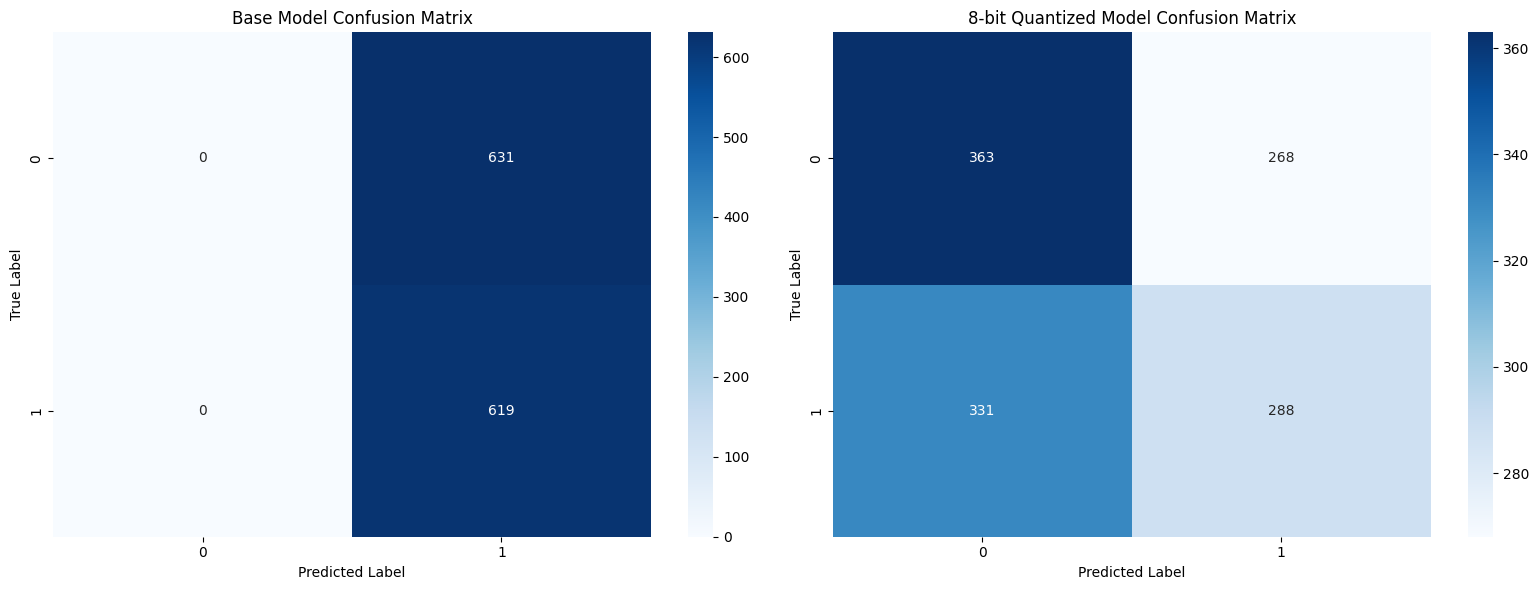


Memory Usage Comparison:
--------------------------------------------------
Base Model Memory: 583.40 MB
Quantized Model Memory: -0.41 MB
Memory Savings: 583.81 MB


In [22]:
# Clear memory before testing
torch.cuda.empty_cache()

# Select a subset of the test dataset for comprehensive evaluation
# Using more examples for better statistical significance
test_subset = imdb['test']

# Run the comparison between base model and quantized model
comparison_results = compare_model_accuracy(
    model1=model,  # Base model
    model2=quantized_model,  # Quantized model
    test_dataset=test_subset,
    model1_name="Base Model",
    model2_name="8-bit Quantized Model",
    batch_size=32
)

# Print memory usage comparison as a reminder
print("\nMemory Usage Comparison:")
print("-" * 50)
print(f"Base Model Memory: {after_base - before_base:.2f} MB")
print(f"Quantized Model Memory: {after_quantized - before_quantized:.2f} MB")
print(f"Memory Savings: {(after_base - before_base) - (after_quantized - before_quantized):.2f} MB")


In [ ]:
tok_datasets = imdb.map(tok_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
import torch
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
from transformers import Trainer
trainer = Trainer(
    model,
    get_args(), 
    train_dataset=tok_datasets['train'],
    eval_dataset=tok_datasets['test'],
    data_collator=data_collator, 
    processing_class=tokenizer
)
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss
1,No log,0.509825
2,No log,0.322631
3,0.248900,0.316185


TrainOutput(global_step=627, training_loss=0.20701909711676542, metrics={'train_runtime': 65.5277, 'train_samples_per_second': 57.228, 'train_steps_per_second': 9.568, 'total_flos': 1553625500069832.0, 'train_loss': 0.20701909711676542, 'epoch': 3.0})

In [ ]:
trainer.save_model("trained_model")

In [ ]:
preds = trainer.predict(tok_datasets['test'])
pred_labels = preds.predictions.argmax(-1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(tok_datasets['test']['label'], pred_labels))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       631
           1       0.91      0.94      0.92       619

    accuracy                           0.92      1250
   macro avg       0.92      0.92      0.92      1250
weighted avg       0.92      0.92      0.92      1250



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(tok_datasets['test']['label'], pred_labels))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       631
           1       0.79      0.86      0.82       619

    accuracy                           0.82      1250
   macro avg       0.82      0.82      0.81      1250
weighted avg       0.82      0.82      0.81      1250



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(tok_datasets['test']['label'], pred_labels))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       631
           1       0.92      0.94      0.93       619

    accuracy                           0.93      1250
   macro avg       0.93      0.93      0.93      1250
weighted avg       0.93      0.93      0.93      1250

